In [ ]:
#default_exp optimizers_07

In [ ]:
#export
from ModernArchitecturesFromScratch.basic_operations_01 import *
from ModernArchitecturesFromScratch.fully_connected_network_02 import *
from ModernArchitecturesFromScratch.model_training_03 import *
from ModernArchitecturesFromScratch.convolutions_pooling_04 import *
from ModernArchitecturesFromScratch.callbacks_05 import *
from ModernArchitecturesFromScratch.batchnorm_06 import *
from functools import partial
import matplotlib.pyplot as plt

# Optimizers
> Create a template for advanced optimizers and implement Adam with easy customization

In [ ]:
#export
#hide
class Parameter():
    "Defines a base class for all parameters that need to be learned by the model"
    def __init__(self, data=None, requires_grad=True):
        self.d = torch.Tensor() if data is None else data
        self.requires_grad = requires_grad
        self.grad = 0.
    
    def step(self, lr): 
        self.d -= lr * self.grad
    
    def zero_grad(self): self.grad = 0.
    
    def update(self, amount): self.grad = amount
        
    def __get__(self, instance, owner): return self.d
        
    def __repr__(self): 
        return f'Parameter: {self.d.shape}, Requires grad: {self.requires_grad}'

## Steppers

In [ ]:
#export
def sgd_step(p, lr, **kwargs):
    "Perofms a basic sgd step for the optimizer"
    p.d -= lr * p.grad

def l2_reg_step(p, wd,**kwargs):
    "Adds weight decay regularization to the gradients"
    p.grad += wd * p.d

def update_defaults(defaults, passed):
    "A way to update the default hyperparameters of the network"
    for ok,ov in defaults.items():
        if ok not in passed:
            passed[ok] = ov
    return passed

## Optimizer v2

Class for optimizer with param groups and default hyperparameters

In [ ]:
class NewOptimizer():
    "Optimizer to handle different step functions and hyperparameters"
    def __init__(self, params, step_fcns=[sgd_step], **defaults):
        _defaults = {'lr':0.1, 'wd':1e-4}
        defaults = update_defaults(_defaults, defaults)
        
        #Make params a list of lists
        self.params = list(params)
        if not isinstance(self.params[0],list): self.params = [self.params]
            
        self.hypes = [{**defaults} for p in self.params]
        self.step_fcns = step_fcns

    def step(self):
        for pg,hype in zip(self.params,self.hypes): 
            for p in pg:
                for step in self.step_fcns:
                    step(p, **hype)

    def zero_grad(self):
        for pg in self.params: 
            for p in pg:
                p.zero_grad()

In [ ]:
#export
#hide
class Learner():
    def __init__(self, model, loss_func, optimizer, db, **kwargs):
        "Wrapper for model, loss function, optimizer and databunch"
        self.model, self.loss_func, self.optimizer, self.db = model, loss_func, optimizer(model.parameters(), **kwargs), db
    
    def __repr__(self): return f'Data: \n {self.db} \n Model: \n {self.model}'

In [ ]:
m,_,lf = get_linear_model(0.1)
o = NewOptimizer
db = get_mnist_databunch()
learn = Learner(m,lf,o,db, step_fcns=[l2_reg_step, sgd_step])
run = Runner(learn,[Stats([accuracy]), ProgressCallback()])

In [ ]:
run.fit(1, 0.5)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.287021,0.914040,0.194590,0.941180,00:01


# Momentum

In [ ]:
#export
def update_default_states(stats, state, init):
    "A way to populate a dictionary with default states"
    for stat in stats:
        for k,v in init(stat).items():
            state[k] = v

In [ ]:
#export
class StatedOptimizer():
    "Optimizer with ability to keep and update various parameter states"
    def __init__(self, params, step_fcns=[sgd_step], stats=[], **defaults):
        _defaults = {'lr':0.1, 'wd':1e-4, 'mom':0.9, 'sqr_mom': 0.99}
        defaults = update_defaults(_defaults, defaults)
        
        #Make params a list of lists
        self.params = list(params)
        if not isinstance(self.params[0],list): self.params = [self.params]
            
        self.stats = stats
        self.state = {}
        
        self.hypes = [{**defaults} for p in self.params]
        self.step_fcns = step_fcns

    def step(self):
        i = 0
        for p,hype in self.grad_params(): 
            if p not in self.state:
                self.state[p] = {}
                update_default_states(self.stats, self.state[p], lambda o: o.init_state(p))

            state = self.state[p]
            for stat in self.stats: 
                state = stat.update(p, state, **hype)
                
            for step in self.step_fcns: step(p, **state, **hype)
                
            self.state[p] = state

    def zero_grad(self):
        for pg in self.params: 
            for p in pg:
                p.zero_grad()
    
    def grad_params(self):
        return [(p,hyper) for pg,hyper in zip(self.params,self.hypes)
            for p in pg if p.grad is not None]

In [ ]:
#export
class OptimStat():
    "Base class for stats to be kept track of in the optimizer"
    def init(self, pg): raise NotImplementedError
    def update(self, pg, state, **kwargs): raise NotImplementedError

In [ ]:
#export
class AverageGrad(OptimStat):
    "Keeps track of the exponentially weighted moving average of the gradients"
    def init_state(self, p): return {'grad_avg': torch.zeros(p.d.shape)}
    
    def update(self, p, state, mom, **kwargs):
        state["grad_avg"] = state["grad_avg"] * mom + (1-mom)*p.grad
        return state

In [ ]:
#export
def momentum_step(p, lr, grad_avg, **kwargs):
    "Does a step of the learning rate based on the exponential moving average of the gradient"
    p.d -= lr * grad_avg

In [ ]:
m,_,lf = get_linear_model(0.1)
o = StatedOptimizer
db = get_mnist_databunch()
learn = Learner(m,lf,o,db, step_fcns=[momentum_step, l2_reg_step], stats=[AverageGrad()])
run = Runner(learn,[Stats([accuracy]), ProgressCallback()])

In [ ]:
run.fit(1,0.001)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.306740,0.906840,0.172461,0.947620,00:01


## Adding Dampening

In [ ]:
#export
class OptimCounter(OptimStat):
    "Keeps track of how many optimizer steps were taken"
    def init_state(self,p): return {'steps_taken': 0}
    def update(self, p, state, **kwargs):
        state['steps_taken'] += 1
        return state

In [ ]:
#export
class AverageGrad(OptimStat):
    "Keeps track of the exponentially weighted moving average of the gradients"
    def __init__(self, dampening:bool=False): self.damp = dampening
    
    def init_state(self, p): return {'grad_avg': torch.zeros(p.d.shape)}
    
    def update(self, p, state, mom, **kwargs):
        state['damp_mom'] = 1-mom if self.damp else 1. 
        state['grad_avg'] = state['grad_avg']*mom + state["damp_mom"] * p.grad.data
        return state

In [ ]:
#export
class AverageSquaredGrad(OptimStat):
    "Keeps track of the exponentially weighted moving average of the gradients"
    def __init__(self, dampening:bool=True): self.damp = dampening
    
    def init_state(self, p): return {'sqr_grad_avg': torch.zeros(p.d.shape)}
    
    def update(self, p, state, sqr_mom, **kwargs):
        state['sqr_damp_mom'] = 1-sqr_mom if self.damp else 1. 
        state["sqr_grad_avg"] = state["grad_avg"] * sqr_mom + state['sqr_damp_mom']*(p.grad**2)
        return state

In [ ]:
#export
def debias(mom, damp, step): 
    "Debiases the terms if momentum is or isn't used"
    return damp * (1 - mom**step) / (1-mom)

def adam_step(p, lr, mom, damp_mom, steps_taken, sqr_mom, sqr_damp_mom, grad_avg, sqr_grad_avg, eps=1e-5, **kwargs):
    "Performs an Adam step of the optimizer"
    debias1 = debias(mom, damp_mom, steps_taken)
    debias2 = debias(sqr_mom, sqr_damp_mom, steps_taken)
    p.d += -lr / debias1 * (grad_avg / (sqr_grad_avg/debias2).sqrt() + eps)
    return p

In [ ]:
#export
from functools import partial
def adam_opt(beta1=0.9, beta2=0.99):
    "Returns an adam optimizer with momentum parameters beta1 and beta2"
    return partial(StatedOptimizer, step_fcns=[adam_step,l2_reg_step],
                   stats=[AverageGrad(dampening=True), AverageSquaredGrad(), OptimCounter()], mom=beta1, sqr_mom=beta2)

In [ ]:
#hide
#export
#export
class Runner():
    "All encompossing class to train a model with specific callbacks"
    def __init__(self, learner, cbs=None):
        cbs = [] if cbs is None else cbs
        self.stop,self.cbs = False,[TrainEvalCallback()]+cbs
        
        for cb in self.cbs:
            cb.runner = self
            
        self.learner = learner
    
    @property
    def model(self): return self.learner.model
    @property
    def optimizer(self): return self.learner.optimizer
    @property
    def loss_func(self): return self.learner.loss_func
    @property
    def databunch(self): return self.learner.db
    @property
    def dl(self): return self.learner.db.train if self.model.training else self.learner.db.valid
    
    def do_one_batch(self, xb, yb):
        "Applies forward and backward passes of model to one batch"
        self.xb, self.yb = xb, yb
        
        self.pred = self.learner.model(xb)
        self.loss = self.learner.loss_func(self.pred, yb)
        if self.check_callbacks('after_loss') or not self.learner.model.training: return
        
        self.learner.loss_func.backward()
        if self.check_callbacks('after_loss_back'): return
        
        self.learner.model.backward()
        if self.check_callbacks('after_model_back'): return
        
        self.optimizer.step()
        if self.check_callbacks('after_opt'): return
        
        self.optimizer.zero_grad()
        if self.check_callbacks('after_zero_grad'): return
    
    def do_all_batches(self, dl):
        "Runs every batch of a dataloader through `do_one_batch`"
        self.iters, self.iters_done = len(dl), 0
        for xb, yb in dl:
            if self.stop: break
            self.xb, self.yb = xb,yb
            if self.check_callbacks('before_batch'): return
            self.do_one_batch(self.xb,self.yb)
            if self.check_callbacks('after_batch'): return
        self.iters = 0
            
        self.stop = False

    def fit(self, epochs, lr=0.1):
        "Method to fit the model `epoch` times using learning rate `lr`"
        for hype in self.optimizer.hypes: hype['lr'] = lr
        self.epochs = epochs
        if self.check_callbacks('before_fit'): return
        
        for epoch in range(epochs):
            self.epoch = epoch
            if self.check_callbacks('before_epoch'): return
            if not self.check_callbacks('before_train'): self.do_all_batches(self.learner.db.train)
            if not self.check_callbacks('before_valid'): self.do_all_batches(self.learner.db.valid)
            if self.check_callbacks('after_epoch'): break
        
        if self.check_callbacks('after_fit'): return
    
    def check_callbacks(self, state):
        "Helper functions to run through each callback, calling it's state method if applicable"
        for cb in sorted(self.cbs, key=lambda x: x._order):
            f = getattr(cb, state, None)
            if f and f(): return True
        return False
    
    def __repr__(self): return f'{self.learner} \n Callbacks: \n {self.cbs}'

In [ ]:
m,lf = get_conv_model(), CrossEntropy()
o = adam_opt()
db = get_mnist_databunch()
learn = Learner(m,lf,o,db)
run = Runner(learn,[Stats([accuracy]), ProgressCallback(), HyperRecorder(['lr'])])

In [ ]:
run.fit(1, 0.001)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.397584,0.884680,0.301798,0.915960,00:50


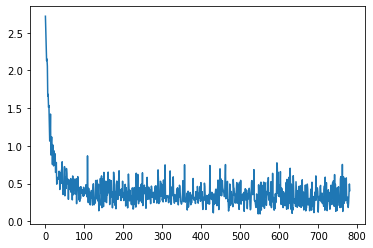

In [ ]:
run.cbs[3].plot_loss()